# Introduction

The value of demographic information implied by the ticket combination of Kaggle Titanic data sets has been widely understated. In this post I'm going to expose demographic information hidden in the join tabular data of the training set and test set offered by Kaggle. Hopefully in my future post I can build on it to evaluate to what extent these new features help us boost our prediction accuracy. It's worthnoting that if you are concerned about data leakage that araises in data processing before splitting the data set, you may find this [discussion](https://www.kaggle.com/c/titanic/discussion/41928#235524) interesting. For the purose that is more of winning the competition than generalization, I'll simply use the full data set as the basis of feature eningeering and leave the data leakage judgement for you.

The main Python libraries I'm going to use are no more than Pandas, NumPy and Seaborn. Here is the outline of questions/tasks I'm going to deal with:

- [Preliminary summary statistics](#preliminary-summary-statistics)
- [Ticket combination: the evidence of travel companion](#ticket-combination)
- [Size of travel group: the pool of travel family and non-biologically-related members](#size-travel-group)
- [Survival rate estimates for each travel group](#survival-rate-estimates)
- [Types of family roles](#family-role)
- [Adults traveling with children](#adult-travel-children)
- [Children traveling with parents](#child-travel-parents)
- [Who is the mother or father of a child](#mom-data-identification)
- [Did the child's mom survive](#check-mom-survive)

There are two tasks not related to the data exploration but found worth noting for my future reference:
- [Apply KNN algorithm on the imputation of missing Embarked feature](#knn-missing-embarked)
- [Charting stacked survival count by gender across age groups --- Seaborn.Facegrid with custom functions recipe](#stacked-survival-count)

# Imputation and feature transformation

<a id="preliminary-summary-statistics"></a>
#### Preliminary summary statistics
I'm going to focuse on checking to see the missing value, data type of each feature.

In [1]:
# Library we need 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure Visualization Defaults
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12, 8
sns.set_style('white')
pd.set_option('display.max_columns', None)

In [2]:
# Replace the following two directories with those in the following comments
df_train = pd.read_csv(r'F:\GitHubData\Titanic\train.csv') # r"../input/train.csv"
df_test = pd.read_csv(r'F:\GitHubData\Titanic\test.csv') # r"../input/test.csv"

# inconsistent columns so we 
# use concat, rather than pd.merge(df_train, df_test, on = [...], how = 'inner')
df_all = pd.concat([df_train, df_test], join='outer', axis=0) 
df_train.name = 'Training data'
df_test.name = 'Test data'

# We have 11 features and 1 target variables
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [3]:
# Dataset Dimensions
print(f'Number of Training Examples: {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}')
print(f'Shape of Training Examples = {df_train.shape}')
print(f'Shape of Test Examples = {df_test.shape}')

Number of Training Examples: 891
Number of Test Examples = 418
Shape of Training Examples = (891, 12)
Shape of Test Examples = (418, 11)


In [4]:
# Column name we have
print(sorted(df_train.columns.tolist())) 
print(sorted(df_test.columns.tolist()))

['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']
['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket']


In [5]:
# Numeric variables in training set
print(df_train.describe(include=[np.number]).T)
print('-' * 30)
# Categorical variables in training set
print(df_train.describe(include=['O']).T)

             count        mean         std   min       25%       50%    75%  \
PassengerId  891.0  446.000000  257.353842  1.00  223.5000  446.0000  668.5   
Survived     891.0    0.383838    0.486592  0.00    0.0000    0.0000    1.0   
Pclass       891.0    2.308642    0.836071  1.00    2.0000    3.0000    3.0   
Age          714.0   29.699118   14.526497  0.42   20.1250   28.0000   38.0   
SibSp        891.0    0.523008    1.102743  0.00    0.0000    0.0000    1.0   
Parch        891.0    0.381594    0.806057  0.00    0.0000    0.0000    0.0   
Fare         891.0   32.204208   49.693429  0.00    7.9104   14.4542   31.0   

                  max  
PassengerId  891.0000  
Survived       1.0000  
Pclass         3.0000  
Age           80.0000  
SibSp          8.0000  
Parch          6.0000  
Fare         512.3292  
------------------------------
         count unique              top freq
Name       891    891  Flynn, Mr. John    1
Sex        891      2             male  577
Ticket     8

In [6]:
# Missing values
def displayMissing(df):
    for col in df.columns.tolist():
        print(f'{col:11s} NO. missing values: {df[col].isnull().sum()}')

for i, df in enumerate([df_train, df_test]):
    print(f'{df.name}')
    displayMissing(df)
    if i == 0: print('-' * 30) 

Training data
PassengerId NO. missing values: 0
Survived    NO. missing values: 0
Pclass      NO. missing values: 0
Name        NO. missing values: 0
Sex         NO. missing values: 0
Age         NO. missing values: 177
SibSp       NO. missing values: 0
Parch       NO. missing values: 0
Ticket      NO. missing values: 0
Fare        NO. missing values: 0
Cabin       NO. missing values: 687
Embarked    NO. missing values: 2
------------------------------
Test data
PassengerId NO. missing values: 0
Pclass      NO. missing values: 0
Name        NO. missing values: 0
Sex         NO. missing values: 0
Age         NO. missing values: 86
SibSp       NO. missing values: 0
Parch       NO. missing values: 0
Ticket      NO. missing values: 0
Fare        NO. missing values: 1
Cabin       NO. missing values: 327
Embarked    NO. missing values: 0


As pointed out in many exploratory data analysis on Kaggle Titanic data set, we have missing values in continuous features `Age` and `Fare` and nominal variables `Embarked` and `Cabin`. 

<a id="ticket-combination"></a>
#### Ticket combination

In [7]:
# todo:  Ticket combination is the feature without any missing values.
# We should try to extract any information from it
# although it appears useless at the first glance.
def getTicketPrefixAndNumber(df, col):
    # naming the columns to be created
    col_num = col + '_num'
    col_alp = col + '_alp'

    # get the last group of contiguous digits
    # vectorize string function with str method
    # get any contignuous nuemrical digits from the end
    # return anything that matches the pattern specified inside the parenthesis 
    df[col_num] = df[col].str.extract(r'(\d+)$')
    df[col_num].fillna(-1, inplace=True)

    # get the complete string before a space that is followed by a trailing number group
    df[col_alp] = df[col].str.extract(r'(.*)\ \d+$')
    # sidenote: .replace({'\.': '', '/': ''}, regex=True)
    df[col_alp].fillna('M', inplace=True)
    return df

print(getTicketPrefixAndNumber(df_all, 'Ticket').head())

   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Ticket_num Ticket_alp  
0      0         A/5 21171   7.2500   NaN        S      21171        A/5  
1      0          PC 17599  71.2833   C85        C      17599         PC  
2      0  STON/O2. 3101282   7.9250   NaN        S    3101282   STON/O2.  
3      0            

In [8]:
print(df_all.Ticket_num.describe())
print('-' * 30) 
df_all['Ticket_num'] = pd.to_numeric(df_all['Ticket_num'])
print(df_all.Ticket_num.describe())

count     1309
unique     924
top       2343
freq        11
Name: Ticket_num, dtype: object
------------------------------
count    1.309000e+03
mean     2.830713e+05
std      6.353943e+05
min     -1.000000e+00
25%      1.356700e+04
50%      1.108130e+05
75%      3.470750e+05
max      3.101317e+06
Name: Ticket_num, dtype: float64


In [9]:
# check to see if the string decomposition works as expected.
colnames = ['Ticket' + s for s in ['', '_num', '_alp']]
print(df_all[colnames].head())

             Ticket  Ticket_num Ticket_alp
0         A/5 21171       21171        A/5
1          PC 17599       17599         PC
2  STON/O2. 3101282     3101282   STON/O2.
3            113803      113803          M
4            373450      373450          M


#### Travel group - use of transform()
Are there any people sharing the same ticket number but actually come from different travel groups (identified by ticket combination)? The answer is Yes. In such a case, I use `Ticket`, rather than `Ticket_num` to define a travel group. Using `last name` to define a travel group as seen in many kernels is not good enough for my purpose. People travelling together as a group should bear similar characteristics related to their survival rates in this travel disaster. Members of a travel group do not necessary share biological relathinship.

In [10]:
islice = df_all.groupby('Ticket_num')['Ticket_alp'].transform(lambda x: x.nunique() > 1)
print(df_all.loc[islice,:].sort_values(by=['Ticket_num']).head(6))

     PassengerId  Survived  Pclass                              Name     Sex  \
226          227       1.0       2         Mellors, Mr. William John    male   
648          649       0.0       3                Willey, Mr. Edward    male   
570          571       1.0       2                Harris, Mr. George    male   
155         1047       NaN       3              Duquemin, Mr. Joseph    male   
279          280       1.0       3  Abbott, Mrs. Stanton (Rosa Hunt)  female   
746          747       0.0       3       Abbott, Mr. Rossmore Edward    male   

      Age  SibSp  Parch         Ticket   Fare Cabin Embarked  Ticket_num  \
226  19.0      0      0      SW/PP 751  10.50   NaN        S         751   
648   NaN      0      0  S.O./P.P. 751   7.55   NaN        S         751   
570  62.0      0      0    S.W./PP 752  10.50   NaN        S         752   
155  24.0      0      0  S.O./P.P. 752   7.55   NaN        S         752   
279  35.0      1      1      C.A. 2673  20.25   NaN        

#### Survival rate - use of pd.merge()
Check to see if survival rate (based on available Survived feature) varies across ticket combinations.

In [11]:
gtb1 = df_all[['Survived', 'Ticket']].groupby(['Ticket'])
# compute the groupwise survival rates (percentage) # pd.count() counts non-NA cells
temp = (gtb1['Survived'].sum() / gtb1['Survived'].count() * 100).sort_values()
# name the resulting column to be used in the merge below
temp.name = 'TeamSurvivalRate'
# one-to-many merge on column Ticket
df_all = pd.merge(df_all, temp, on='Ticket')

<a id="size-travel-group"></a>
#### Size of family and travel group - use of double groupby() & reset_index()
Check if there exist travel groups with members of size larger than 5.

Note: `pd.count()` doesn't count NA cells. If use it rather than `pd.size()` to count group size on Survived feature, the resulting group size is not correct.

In [12]:
df_all.loc[df_all.groupby('Ticket')['Survived'].transform('size') > 5, :]['Ticket'].unique()

array(['347082', '382652', '347077', '19950', '3101295', 'CA 2144',
       '347088', 'S.O.C. 14879', '1601', 'CA. 2343', '113781', 'PC 17608'],
      dtype=object)

For example, the travel group of ticket combination `S.O.C. 14879` has more than five members (two of which have unknown Survived features).

In [13]:
print(df_all.loc[df_all.Ticket=='S.O.C. 14879',['Ticket', 'Survived']])

           Ticket  Survived
149  S.O.C. 14879       0.0
150  S.O.C. 14879       0.0
151  S.O.C. 14879       0.0
152  S.O.C. 14879       0.0
153  S.O.C. 14879       0.0
154  S.O.C. 14879       NaN
155  S.O.C. 14879       NaN


For example, the family of ticket combination `PC 17608` travles in a group with two other non-biological relationship members `PassengerId` = 951 and 1267.

In [14]:
print(df_all.loc[df_all['Ticket'] == 'PC 17608',:])

     PassengerId  Survived  Pclass  \
504          312       1.0       1   
505          743       1.0       1   
506          916       NaN       1   
507          951       NaN       1   
508          956       NaN       1   
509         1034       NaN       1   
510         1267       NaN       1   

                                                Name     Sex   Age  SibSp  \
504                       Ryerson, Miss. Emily Borie  female  18.0      2   
505            Ryerson, Miss. Susan Parker "Suzette"  female  21.0      2   
506  Ryerson, Mrs. Arthur Larned (Emily Maria Borie)  female  48.0      1   
507                      Chaudanson, Miss. Victorine  female  36.0      0   
508                      Ryerson, Master. John Borie    male  13.0      2   
509                       Ryerson, Mr. Arthur Larned    male  61.0      1   
510                         Bowen, Miss. Grace Scott  female  45.0      0   

     Parch    Ticket     Fare            Cabin Embarked  Ticket_num  \
504    

Besides, here is the biggest family/group in the Titanic data:

In [15]:
print(df_all.loc[df_all['Ticket'] == 'CA. 2343',:])

     PassengerId  Survived  Pclass                               Name     Sex  \
283          160       0.0       3         Sage, Master. Thomas Henry    male   
284          181       0.0       3       Sage, Miss. Constance Gladys  female   
285          202       0.0       3                Sage, Mr. Frederick    male   
286          325       0.0       3           Sage, Mr. George John Jr    male   
287          793       0.0       3            Sage, Miss. Stella Anna  female   
288          847       0.0       3           Sage, Mr. Douglas Bullen    male   
289          864       0.0       3  Sage, Miss. Dorothy Edith "Dolly"  female   
290         1080       NaN       3                    Sage, Miss. Ada  female   
291         1234       NaN       3              Sage, Mr. John George    male   
292         1252       NaN       3        Sage, Master. William Henry    male   
293         1257       NaN       3     Sage, Mrs. John (Annie Bullen)  female   

      Age  SibSp  Parch    

In [16]:
# If use it rather than `pd.size()` to count group size on Survived feature, 
# the resulting group size is not correct.
df_all.loc[df_all.groupby('Ticket')['Survived'].transform('count') > 5, :]['Ticket'].unique()

array(['347082', '3101295', 'CA 2144', '347088', '1601', 'CA. 2343'],
      dtype=object)

Trave group varies in size. I create a feature `TeamSize` to count the total number of people in a group of the same ticket comibnation. For the estimate of family size, it is pretty straightforward to account for the entry itself in addition to the number of its siblings, parents and childrens.

In [17]:
df_all['TeamSize'] = df_all.groupby('Ticket')['Survived'].transform(lambda x: x.shape[0]) # ~ x.size

In [18]:
# The correct size of a family
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1

The following code shows that more than $76\%$ of travel groups are composed of one person only. 

In [19]:
# To have a sense of the distribution of TeamSize
g = df_all.groupby(['Ticket']).first()['TeamSize'].value_counts()
ans = g / g.sum() * 100 # convert to percentrage
# Tabularize
ans.index = ans.index.astype(int)
ans.index.name = 'Group Size'
print(pd.DataFrame(ans).rename(columns={'TeamSize': 'Percentage'}).T)

Group Size         1          2         3         4         5         7   \
Percentage  76.749193  14.208827  5.274489  1.722282  0.753498  0.538213   

Group Size        6         8         11  
Percentage  0.430571  0.215285  0.107643  


The following code shows that team size might be a useful predictor for survival rates.

In [20]:
df_all.groupby(['TeamSize','Ticket'])['TeamSurvivalRate'].mean().groupby(level=0).mean()

TeamSize
1.0     27.027027
2.0     50.847458
3.0     65.248227
4.0     68.750000
5.0     39.285714
6.0     25.000000
7.0     35.000000
8.0     35.714286
11.0     0.000000
Name: TeamSurvivalRate, dtype: float64

In [21]:
df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean()

Pclass  TeamSize
1       1.0          44.444444
        2.0          65.217391
        3.0          76.666667
        4.0          80.208333
        5.0          58.333333
        6.0          50.000000
        7.0         100.000000
2       1.0          38.202247
        2.0          51.515152
        3.0          72.222222
        4.0          70.833333
        5.0         100.000000
        7.0           0.000000
3       1.0          20.000000
        2.0          33.333333
        3.0          52.500000
        4.0          43.750000
        5.0           0.000000
        6.0           0.000000
        7.0          25.000000
        8.0          35.714286
        11.0          0.000000
Name: TeamSurvivalRate, dtype: float64

Based on the estimated group survival rate, regardless of passenger class, the top three groups tend to include groups of size four and three.

In [22]:
# This code results in the sorting of Teamsize within passenger class by team survival rate.
print(df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean(). \
    reset_index().sort_values(by=['Pclass','TeamSurvivalRate']))

    Pclass  TeamSize  TeamSurvivalRate
0        1       1.0         44.444444
5        1       6.0         50.000000
4        1       5.0         58.333333
1        1       2.0         65.217391
2        1       3.0         76.666667
3        1       4.0         80.208333
6        1       7.0        100.000000
12       2       7.0          0.000000
7        2       1.0         38.202247
8        2       2.0         51.515152
10       2       4.0         70.833333
9        2       3.0         72.222222
11       2       5.0        100.000000
17       3       5.0          0.000000
18       3       6.0          0.000000
21       3      11.0          0.000000
13       3       1.0         20.000000
19       3       7.0         25.000000
14       3       2.0         33.333333
20       3       8.0         35.714286
16       3       4.0         43.750000
15       3       3.0         52.500000


In [23]:
# We can further obtain the class-wise top three groups in terms of team survival rate.
# Just append "groupby(['Pclass']).tail(3)".
print(df_all.groupby(['Pclass', 'TeamSize'])['TeamSurvivalRate'].mean(). \
    reset_index().sort_values(by=['Pclass','TeamSurvivalRate']).groupby(['Pclass']).tail(3))

    Pclass  TeamSize  TeamSurvivalRate
2        1       3.0         76.666667
3        1       4.0         80.208333
6        1       7.0        100.000000
10       2       4.0         70.833333
9        2       3.0         72.222222
11       2       5.0        100.000000
20       3       8.0         35.714286
16       3       4.0         43.750000
15       3       3.0         52.500000


<a id="survival-rate-estimates"></a>
#### Credibility of group survival rate - use of apply()
The credibility of a group survival rate is measured in terms of the proportion of valid `Survived` feature. I will use it as weights to adjust the `TeamSurvivalRate` feature.

In [24]:
def getCredibilitySurvivalRate(df):
    # Use `size` or `shape[0]` to get the full length of a series
    # When summing over cells of {0,1,NaN}, 
    # regardless of the use of `pd.notnull()`, the outcome is identical.
    df['SRcredibility'] = pd.notnull(df['Survived']).sum() / df['Survived'].size 
    return df

df_all = df_all.groupby('Ticket').apply(getCredibilitySurvivalRate)

<a id="family-role"></a>
#### Type of family roles - use of seaborn.FacetGrid & pandas.melt()
For flexibility in tuning hyper parameters like the age threshold for the definition of a child, I introduce the `cutoff` argument for the maximum child age and set the default cutoff age to 7. Then I do something like a grid search on the integer interval $[1, 29]$ to see the impact of the cutoff age configuratio on the estimate of survival rates by gender.

In [25]:
def getRole(df, cutoff=7):
    df['Role'] = 'Man'
    df.loc[df['Sex'] == 'female', 'Role'] = 'Woman'
    df.loc[df['Age'] <= cutoff, 'Role'] = 'Child'
    return df

ans = []
ages = range(1, 30)
for cut in ages:
    getRole(df_all, cutoff=cut)
    g = df_all.groupby(['Role'])
    # [1] I covert the resulting Pandas series to a data frame object and then append
    # it to the `ans` list object so that I can concatenate them in one step. later.
    ans.append((g['Survived'].sum() / g['Survived'].count()).to_frame())

In [26]:
# [2] To concatnate the data frames stored in the `ans` list object.
temp = pd.concat(ans, axis=1)  # 3 by N (=len(ages))
# [3] convert 3 by N table to N by 3 table
tb1 = pd.DataFrame(np.array(temp).T,
                   columns=['Child', 'Man', 'Woman'], index=ages)  # N by 3
tb1.index.name = 'Age'
# [4] melt the table tb1 for drawing a line plot
tb1.reset_index(inplace=True)  # prep for melt
tb2 = pd.melt(tb1, id_vars=['Age'], value_vars=['Child', 'Man', 'Woman'],
              var_name='Role', value_name='Survival')

Here I'm going to use seaborn facetGrid for drawing the line plot ([searborn.FaceGrid](https://seaborn.pydata.org/generated/seaborn.FacetGrid.html) document).

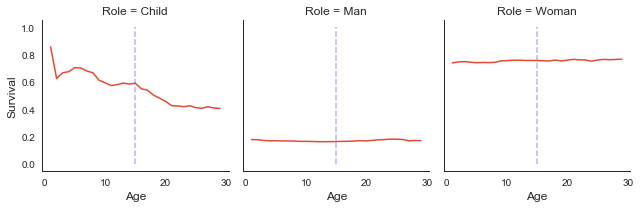

In [27]:
# [5] FacetGrid and mapping plot functions to each grid
g = sns.FacetGrid(tb2, col='Role', margin_titles=True)
g = g.map(plt.plot, 'Age', 'Survival')

# add vertical line
axes = g.fig.axes
for ax in axes:
    ax.vlines(x=15, ymax=1, ymin=0, linestyles='dashed', alpha=0.3, colors='blue')
plt.show()

The child survival rate is trending downward as the maximum age of children is lowered. I want to maximize the number of children with the constraint to maintain the child survival rate at least $60\%$, so I set the hyper parameter of child age to 15.

In [28]:
getRole(df_all, cutoff=15);

<a id="adult-travel-children"></a>
#### Adults traveling with children - use of nampy.where() & unique()

In [29]:
# Use this as an example: df_all.loc[df_all['Ticket_num']==17608,:]
# Step 1. Create a new column for the number of siblings of a child.
df_all['childSibSp'] = np.where(df_all['Role'] == 'Child', df_all['SibSp'], 0)

In [30]:
# Step 2. Is the childSibSp value unique within a travel group? Answer: Yes
logic = df_all['childSibSp']>0 # screen out parents (whose SibSp is at least one) 
df_all.loc[logic,:].groupby('Ticket')['childSibSp'].nunique().value_counts()

1    37
Name: childSibSp, dtype: int64

So, We can use childSibSp to identify siblings of a child. Note that the number 37 is exactly the number of travel group traveling with young children.

In [31]:
# Step 3. Broadcasting: in a group, let every instance of the same group shares the 'childSibSp' value of the youngest child.
df_all['childSibSp'] = df_all.groupby('Ticket')['childSibSp'].transform('max') # 'cz otherwise it's 0 by default.

In [32]:
# Step 4. If an example's SibSp is not equal to the shared value, the instance must be
# a elder child whose age exceeds the age limit for the child definition.
# Condition 1: to prevent updating value of members in travel group without children. Seems redundant (see condition 2).
# Condition 2: 'cz siblings share childSibSp value by construction.
# Condition 3: to prevent the youngest child's value being overwritten.

logic = (df_all['SibSp'] != 0) & \
        (df_all['SibSp'] == df_all['childSibSp']) & \
        (df_all['Role'] != 'Child') 
df_all.loc[logic, 'Role'] = 'olderChild'

Take the travel group of ticket `PC 17608` for instance. I can now identify who is the elder child in the family: `PassengerId` = 312 and 743.

In [33]:
print(df_all.loc[df_all['Ticket'] == 'PC 17608',['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Ticket', 'Role', 'childSibSp']])

     PassengerId  Survived                                             Name  \
504          312       1.0                       Ryerson, Miss. Emily Borie   
505          743       1.0            Ryerson, Miss. Susan Parker "Suzette"   
506          916       NaN  Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
507          951       NaN                      Chaudanson, Miss. Victorine   
508          956       NaN                      Ryerson, Master. John Borie   
509         1034       NaN                       Ryerson, Mr. Arthur Larned   
510         1267       NaN                         Bowen, Miss. Grace Scott   

        Sex   Age  SibSp    Ticket        Role  childSibSp  
504  female  18.0      2  PC 17608  olderChild           2  
505  female  21.0      2  PC 17608  olderChild           2  
506  female  48.0      1  PC 17608       Woman           2  
507  female  36.0      0  PC 17608       Woman           2  
508    male  13.0      2  PC 17608       Child           2  
5

<a id="mom-data-identification"></a>
#### Who is the female and the male household head - use of np.where()
The following code is going to identify the male and female household head if any. The role of the rest of members in the travel group will be left as it was.

In [34]:
# Step 1. Identify the FamilySize value of the youngest child in each travel team.
df_all['childFamilySize'] = np.where(df_all['Role'].isin(['Child', 'olderChild']),
                                     df_all['FamilySize'], 
                                     0)
# Step 2. Broadcasting the FamilySize value of the youngest child to
# other members in the same travel team; by doing so, maid and bultler'r role will stay put
# (either Man or Woman as it was).
df_all['childFamilySize'] = df_all.groupby('Ticket')['childFamilySize'].transform('max')

In [35]:
# Step 3. identy people who are parents
def isMotherOrFather(s):
    return 'Father' if s == 'Man' else 'Mother'

# Condition 1: narrow down the scope to family member only; 
# maid and bultlers are going to be screened out.
# Condition 2: narrow down to people whose role is not "child" or "elder child".
slice_logic = ((df_all['FamilySize'] == df_all['childFamilySize']) & \
               (~df_all['Role'].isin(['Child', 'olderChild'])))

# A trick to obtain the index of valid examples after logical operations.
# However, we may as well substitute slice_index with slice_ligic in this case.
slice_index = df_all.loc[slice_logic, :].index
df_all.loc[slice_index, 'Role'] = \
    df_all.loc[slice_logic, :]['Role'].apply(isMotherOrFather)

<a id="child-travel-parents"></a>
#### Children traveling with parents - np.where()
Here I am going to identify children traveling with parents. Note that I do need to identify women that travel with their children as in some kernel of this competition, because my approach to reconstruct the family role for mother embodies this consideration. To be specific, an instance with `Role` = 'Mother' implies she traveling with children.

In [36]:
df_all['ChildWAdult'] = 'Not Applicable'
logic = (df_all['Role'].isin(['Child', 'olderChild']))
df_all.loc[logic, 'ChildWAdult'] = np.where(
    df_all.loc[logic, 'FamilySize'] > df_all.loc[logic, 'childSibSp'] + 1,
    'Yes',
    'No'
)

In [37]:
cols = ['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Ticket', 'Role', 'Embarked', 'Fare']
print(df_all.loc[df_all['Ticket'] == 'PC 17608', cols])

     PassengerId  Survived                                             Name  \
504          312       1.0                       Ryerson, Miss. Emily Borie   
505          743       1.0            Ryerson, Miss. Susan Parker "Suzette"   
506          916       NaN  Ryerson, Mrs. Arthur Larned (Emily Maria Borie)   
507          951       NaN                      Chaudanson, Miss. Victorine   
508          956       NaN                      Ryerson, Master. John Borie   
509         1034       NaN                       Ryerson, Mr. Arthur Larned   
510         1267       NaN                         Bowen, Miss. Grace Scott   

        Sex   Age  SibSp    Ticket        Role Embarked     Fare  
504  female  18.0      2  PC 17608  olderChild        C  262.375  
505  female  21.0      2  PC 17608  olderChild        C  262.375  
506  female  48.0      1  PC 17608      Mother        C  262.375  
507  female  36.0      0  PC 17608       Woman        C  262.375  
508    male  13.0      2  PC 176

My approach to reconstruct the family role looks fine so far. However, a closer look reveals something fishy. The following code shows two couples were mistakenly classified as child (`PassengerId` = 10 and 123 along with `PassengerId` = 831 and 621). Besides, we may impute the missing value of age for `PassengerId` = 241 by her sibling's age (`PassengerId` = 112). They are couples of child marriage. I am going to fix this problem and conduct a quick imputation with the code following afte the table below.

In [38]:
print(df_all.loc[df_all.ChildWAdult=='No', cols].sort_values(by=['Ticket']).head(10))

      PassengerId  Survived                                     Name     Sex  \
828          1122       NaN              Sweet, Mr. George Frederick    male   
18             10       1.0      Nasser, Mrs. Nicholas (Adele Achem)  female   
19            123       0.0                     Nasser, Mr. Nicholas    male   
79             40       1.0              Nicola-Yarred, Miss. Jamila  female   
80            126       1.0             Nicola-Yarred, Master. Elias    male   
833           831       1.0  Yasbeck, Mrs. Antoni (Selini Alexander)  female   
832           621       0.0                      Yasbeck, Mr. Antoni    male   
222           241       0.0                    Zabour, Miss. Thamine  female   
221           112       0.0                     Zabour, Miss. Hileni  female   
1032          876       1.0         Najib, Miss. Adele Kiamie "Jane"  female   

       Age  SibSp  Ticket        Role Embarked     Fare  
828   14.0      0  220845       Child        S  65.0000  
18 

In [39]:
# age imputation
logic = df_all['PassengerId'] == 241
df_all.loc[logic, 'Age'] = 14.5
logic = df_all['PassengerId'].isin([10, 831])
df_all.loc[logic, 'Role'] = 'Woman'
logic = df_all['PassengerId'].isin([621, 123])
df_all.loc[logic, 'Role'] = 'Man'

In [40]:
print(df_all.loc[df_all['Ticket']=='2666',cols])

     PassengerId  Survived                                   Name     Sex  \
662          449       1.0         Baclini, Miss. Marie Catherine  female   
663          470       1.0          Baclini, Miss. Helene Barbara  female   
664          645       1.0                 Baclini, Miss. Eugenie  female   
665          859       1.0  Baclini, Mrs. Solomon (Latifa Qurban)  female   

       Age  SibSp Ticket    Role Embarked     Fare  
662   5.00      2   2666   Child        C  19.2583  
663   0.75      2   2666   Child        C  19.2583  
664   0.75      2   2666   Child        C  19.2583  
665  24.00      0   2666  Mother        C  19.2583  


#### Number of children per travel group - use of transform() & isin()

In [41]:
# todo: How many children in this group?
# Method 1.
df_all['NumChild'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: x.isin(['Child', 'olderChild']).sum())
df_all['NumYoungChild'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: x.isin(['Child']).sum())

In [42]:

# # This works as well.
# #Method 2.
# numChildDict = df_all.groupby('Ticket')['Age']\
#     .apply(lambda x: (x <= cutoffChildAge).sum()).reset_index(name='NumChild')
# df_all.join(numChildDict, on='Ticket')

In [43]:

# # Comment out this block 'cz the conclusion seems shaky.

# # Although the survival rate by number of child varies, the highest survival rate estimate
# # falls in family of three children and it holds across classes.
# print(df_all.groupby(['Pclass', 'NumChild'])['Survived'].mean())
# # So, number of children should be another good predictor;
# # In passenger classes 1 and 2, families with three children have higher
# # estimated survival rates.


In [44]:
##
df_all['youngestChildSurvived'] = 'Not Applicable'
df_all.groupby('Ticket').\
    apply(lambda x: ((x['Role'] == 'Child') & (x['Survived'] == 1)).sum() > 0).value_counts()

False    892
True      37
dtype: int64

#

#### Do children with mom have higher survival rates than those with dad? - use of where() & transform()

Note: In Method 1, if you move ['Role'] inside transform's lambda function, it fails.

In [45]:
# Method 1. The usual method for broadcasting simple logical operations.

df_all['hasMother'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: (x == 'Mother').sum() > 0)
df_all['hasFather'] = df_all.groupby('Ticket')['Role'].\
    transform(lambda x: (x == 'Father').sum() > 0)
df_all['hasBothParents'] = np.where(
    df_all['hasMother'] & df_all['hasFather'],
    True,
    False
)

In [46]:
# Method 2. Advanced Method: more complicated logical operations
logics = [(df_all['hasFather'] & ~df_all['hasMother'], 'with Father'),
          (df_all['hasFather'] & df_all['hasMother'], 'with Both'),
          (~df_all['hasFather'] & df_all['hasMother'], 'with Mother'),
          (~df_all['hasFather'] & ~df_all['hasMother'], 'without Parents')]
for logic, s in logics:
    ans = df_all.loc[df_all['Age'] <= 17, :].loc[logic, :].\
        groupby('Ticket')['Survived'].mean().mean()
    print(f"{s:>15} {ans: .2f}")

    with Father  0.75
      with Both  0.55
    with Mother  0.78
without Parents  0.58


In [47]:
# Sanity check for groups with only male household head.
index = df_all.loc[(df_all['hasFather'])&~(df_all['hasMother']),:].index
df_all.loc[index,:].groupby('Ticket').groups.keys()

dict_keys(['230080', '248727', '2699', '349256', 'A/5. 851'])

Take travel group of ticket combination `230080` for example. This is the travel group with only male household head.

In [48]:
print(df_all.loc[df_all['Ticket']=='230080', cols])

     PassengerId  Survived                                      Name   Sex  \
266          149       0.0  Navratil, Mr. Michel ("Louis M Hoffman")  male   
267          194       1.0                Navratil, Master. Michel M  male   
268          341       1.0            Navratil, Master. Edmond Roger  male   

      Age  SibSp  Ticket    Role Embarked  Fare  
266  36.5      0  230080  Father        S  26.0  
267   3.0      1  230080   Child        S  26.0  
268   2.0      1  230080   Child        S  26.0  


<a id="check-mom-survive"></a>
#### Did the children's mom survive? - use of where() & np.select()

In [49]:

# # See this link: https://medium.com/@ODSC/creating-if-elseif-else-variables-in-python-pandas-7900f512f0e4

# # Method 1. Not exactly what I want. It only identify the entry of mother, but
# # I want the result to be broadcasted to everyone in the same group.
# role = 'Mother'
# #Step 1. Identify a mother's life status
# conditions = [(df_all['Role'] != role), # 'Not applicable'
#               (df_all['Survived'].isnull()), # 'Unknown'
#               (df_all['Survived'] == 1.0), # 'Yes'
#               (df_all['Survived'] == 0.0) # 'No'
#               ]
# choices = ['Not applicable', 'Unknown', 'Yes', 'No']
# df_all['isMotherSurvived'] = np.select(conditions, choices)
# len(df_all[df_all['Role']=='Mother']['isMotherSurvived'].values) # 44 mothers on board

# # Step 2. "Braodcast" the group-specific result to other group members
# # Method 1. Use map + dictionary
# index = df_all[df_all['Role']=='Mother']['Ticket_num'] # step 1-1. get the index
# ss = pd.Series(df_all[df_all['Role']=='Mother']['isMotherSurvived'].values, index=index) # step 1-2. get the value
# df_all['isMotherSurvived'] = df_all['Ticket_num'].map(ss.to_dict()).fillna('not applicable') # step 1-3. use dictionary to update the rest

# # Method 2.
# # https://stackoverflow.com/questions/56708924/broadcast-value-to-dataframe-group-by-condition
# df_all['test3'] = df_all['isMotherSurvived'].where(df_all['Role'].eq('Mother'))\
#     .groupby(df_all['Ticket_num']).transform('first').fillna('not applicable')


The compact version based on the preceding methods 1 and 2.
So, we can do it automatically based on the experimental code block above.

In [50]:
def isSurvived(df_all, role='Mother'):
    # Step 1. Identify a mother's life status
    conditions = [(df_all['Role'] != role),  # 'Not applicable'
                  (df_all['Survived'].isnull()),  # 'Unknown'
                  (df_all['Survived'] == 1.0),  # 'Yes'
                  (df_all['Survived'] == 0.0)  # 'No'
                  ]
    choices = ['Not applicable', 'Unknown', 'Yes', 'No']
    s = 'is' + role + 'Survived'
    df_all[s] = np.select(conditions, choices)
    df_all[s] = df_all[s].where(df_all['Role'].eq(role)) \
        .groupby(df_all['Ticket_num']).transform('first').fillna('Not Applicable')
    return df_all

In [51]:
roles = ['Mother', 'Father', 'Child']
for role in roles:
    isSurvived(df_all, role=role)

#### Extract Deck feature - use of apply() on pandas.Series

Get the prefix of Cabin feature.

In [52]:
def getCabinPrefix(df):
    # 'M' is assigned to missing values
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    return df

In [53]:
getCabinPrefix(df_all)
df_all['Deck'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [54]:

# # def imputeCabinePrefix(df_all):
# df_all['Deck'].value_counts()

# # Check to see if the 2nd half of the combined table are all NaN Survived data
# # (1) iloc works with slicing that includes right endpoint.
# # (2) iloc works with index only, so even though I need 'Survived, I use it separately.
# # (3) isnull() to see if there is any missing value
# df_all.iloc[df_train.shape[0]:, ]['Survived'].isnull().all()

# # Cabin numbers have clusters
# df_all['Cabin'].value_counts()
# # For example, 'B57 B59 B63 B66' corresponds to five persons
# # in the Ryerson family. People in the same cabin share the same
# # Ticket_alp and Ticket_num. These three variables should be highly
# # correlated.
# df_all.loc[df_all['Cabin'] == 'B57 B59 B63 B66']
# # 'B57 B59 B63 B66' maps to Ticket_alp = 'PC', which is a much larger group.
# df_all.loc[df_all['Ticket_alp'] == 'PC']['Survived'].sum()

# # We may check later whether each group can be identified or associated with higher servival rate
# # We may also check to see if couples have higher survival rates
# # Check Family Ryerson. The number of SibSp and Parch might have more information.


#### Last name and title - use of str.extract() & str.split(expand=True) & groups.item()
Extract names and titles

In [55]:
def getLastNameAndTitle(df):
    # (1) https://docs.python.org/2/library/re.html
    # (2) Why this patterns works? See the [reason](https://shorturl.at/uAEM8).
    # (3) This pattern works as well r'^([^,]*)'
    # See the reference [link](https://shorturl.at/dwJMS)
    df['LastName'] = df['Name'].str.extract(r'^(.+?),')
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].\
        str.split('.', expand=True)[0]
    return df

In [56]:
getLastNameAndTitle(df_all);

Sanity check: Is it possible for a family to travel with no-biological-relationship people? The answer is verified again: Yes. 
Take travel group of ticket combination '33112' for example.

In [57]:
print(df_all.loc[df_all['Ticket_num']==33112, cols])

     PassengerId  Survived                                               Name  \
261          146       0.0                       Nicholls, Mr. Joseph Charles   
262          550       1.0                     Davies, Master. John Morgan Jr   
263         1068       NaN                               Sincock, Miss. Maude   
264         1222       NaN  Davies, Mrs. John Morgan (Elizabeth Agnes Mary...   

        Sex   Age  SibSp      Ticket        Role Embarked   Fare  
261    male  19.0      1  C.A. 33112  olderChild        S  36.75  
262    male   8.0      1  C.A. 33112       Child        S  36.75  
263  female  20.0      0  C.A. 33112       Woman        S  36.75  
264  female  48.0      0  C.A. 33112      Mother        S  36.75  


In [58]:

# # Sanity check

# cols = ['Name', 'Title', 'LastName']
# # df_all[cols] works as well
# # colon cannot be ignored in df_all.loc[:,cols]
# df_all.loc[:, cols]

# # finding: People with the same surname may come from different families, for example,
# # check the group of surname 'Davies' we found Ticket #48871 corresponds
# # to three young men; ticket #33112 corresponds to one women of age 48 and
# # and a child with the same surname of age 8. However, an issue is found
# # that just using LastName is not sufficient to locate people of the same
# # family. For example, the record of the woman with Ticket #33112 shows
# # she comes with her two children. By slicing with Ticket #33112, we found the
# # woman indeed has two children whose surnames are different. So, we should only
# # use Ticket_num instead of LastName to identify people traveling together.
# df_all.loc[df_all['LastName'] == 'Davies', :].sort_values(by=['Ticket_num'])


Sanity check: Is it possible to have two Mrs in a travelling group? Answer is NO.

In [59]:
df_all.groupby('Ticket')['Ticket'].\
    apply(lambda x: (x == 'Mrs').sum()).reset_index(name='MrsCount')['MrsCount'].value_counts()

0    929
Name: MrsCount, dtype: int64

##### Example of scanning through groups - indices, keys(), items(), get_group() & broadcasting using join()
- GroupBy.indices
- GroupBy.groups.keys()
- GroupBy.groups.items()
- GroupBy.get_group(gpkey)

Note: the result of GroupBy is treated as dictionary by function `map()`.

In [60]:
# Example of displaying group results
gs = df_all.groupby('Ticket')
type(gs.indices) 

dict

In [61]:
# Method 1. Peek the grouped data by sampling; so only part of the data
# Use of random.sample() and list(map())

import random
sampled_group_key = random.sample(gs.groups.keys(), 100)
group_list = list(map(lambda gpkey: gs.get_group(gpkey), sampled_group_key))
for i, g in enumerate(group_list):
    if len(g) > 1:
        temp = g.loc[:,cols] # Just treat g as a general data frame
        break
print(temp)

     PassengerId  Survived                     Name   Sex   Age  SibSp  \
778          566       0.0     Davies, Mr. Alfred J  male  24.0      2   
779          812       0.0        Lester, Mr. James  male  39.0      0   
780          901       NaN  Davies, Mr. John Samuel  male  21.0      2   

        Ticket Role Embarked   Fare  
778  A/4 48871  Man        S  24.15  
779  A/4 48871  Man        S  24.15  
780  A/4 48871  Man        S  24.15  


In [62]:
# Method 2. scan through the groups
for i, g in gs.groups.items():
    if len(g) > 1:
        temp = gs.get_group(i).loc[:,cols]
        break
print(temp)

     PassengerId  Survived                                               Name  \
417          258       1.0                               Cherry, Miss. Gladys   
418          505       1.0                              Maioni, Miss. Roberta   
419          760       1.0  Rothes, the Countess. of (Lucy Noel Martha Dye...   

        Sex   Age  SibSp  Ticket   Role Embarked  Fare  
417  female  30.0      0  110152  Woman        S  86.5  
418  female  16.0      0  110152  Woman        S  86.5  
419  female  33.0      0  110152  Woman        S  86.5  


In [63]:
# I found: the record of the Christy indicates there are two children but only one shown.
print(df_all.loc[df_all['LastName'] == 'Christy', cols])        

     PassengerId  Survived                           Name     Sex   Age  \
796          581       1.0    Christy, Miss. Julie Rachel  female  25.0   
797         1133       NaN  Christy, Mrs. (Alice Frances)  female  45.0   

     SibSp  Ticket   Role Embarked  Fare  
796      1  237789  Woman        S  30.0  
797      0  237789  Woman        S  30.0  


##### Example of joining the result of GroupBy with join() 

In [64]:
#Broadcasting
#Identify travelling groups with children among which who are parents?
# 
def addMaxParchMinSibSp(grp):
    return pd.Series(
        [grp['Parch'].max(), grp['SibSp'].min()],
        ['maxParch', 'minSibSp']
    )
# JOIN versue MERGE [link](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)
df_all = df_all.join(df_all.groupby('Ticket').apply(addMaxParchMinSibSp), on='Ticket')

In [65]:
print(df_all.loc[:, cols + ['maxParch', 'minSibSp']].sort_values(by=['Ticket']).head(8))

     PassengerId  Survived                                               Name  \
419          760       1.0  Rothes, the Countess. of (Lucy Noel Martha Dye...   
418          505       1.0                              Maioni, Miss. Roberta   
417          258       1.0                               Cherry, Miss. Gladys   
429          586       1.0                                Taussig, Miss. Ruth   
427          263       0.0                                  Taussig, Mr. Emil   
428          559       1.0             Taussig, Mrs. Emil (Tillie Mandelbaum)   
219          111       0.0                     Porter, Mr. Walter Chamberlain   
220          476       0.0                        Clifford, Mr. George Quincy   

        Sex   Age  SibSp  Ticket   Role Embarked   Fare  maxParch  minSibSp  
419  female  33.0      0  110152  Woman        S  86.50         0         0  
418  female  16.0      0  110152  Woman        S  86.50         0         0  
417  female  30.0      0  110152  Wo

##### Example of logical operations - use of where(), numpy.where(), numpy.logical_and(), DataFrame.eq()

In [66]:


# # LOGICAL OPERATIONS
# # Method 1. dataframe.where()
# df_all['isMother'] = False
# df_all['isMother'] = df_all['isMother'].\
#     where((df_all['Title'] != 'Mrs') | (df_all['hasMaster'] != True), True) # If the condition doesn't hold, then ...

# # Method 2. np.where() # If the condition holds, then ...
# df_all['MotherWithMaster'] = np.where( 
#     (df_all['Title'] == 'Mrs') & (df_all['hasMaster'] == True), 
#     True, 
#     False
# )

# df_all.loc[df_all['Title'] == 'Master', :][['Age', 'Survived']].mean()  # 5.48, 57%

# # Method 3. np.logical_and()
# def MWM(df):
#     return df.apply(lambda x: 1 if 
#         np.logical_and(x['Title'] == 'Mrs', x['Sex'] == 'female') 
#         else 0, axis=1) # axis=1 is key to this implementation
# df_all['test'] = MWM(df_all)
# df_all.head(10)

# # BROADCASTING OPERATIONS 
# # Identify teams travelling with mother and children
# # Method 1. use `transform`

# temp1 = df_all.groupby(['Ticket'])['Title'].\
#     transform(lambda x: x.eq('Master').any())
# temp2 = df_all.groupby(['Ticket'])['MotherWithMaster'].\
#     transform(lambda x: x.eq(True).any())
# df_all['GroupWMomChild'] = temp1 & temp2

# # Method 2-A. use apply-turned `dictionary` and `map` IT WORKS!!

# # temp5 = df_all.groupby('Ticket').apply(
# #       lambda x: x['Title'].eq('Master').any() & x['MotherWithMaster'].eq(True).any())
# # df_all['GroupWMomChild_3'] = df_all['Ticket'].map(temp5)

# # Method 2-B. use apply and merge IT WORKS!!

# # temp3 = df_all.groupby(['Ticket']).apply(lambda x: x['Title'].eq('Master').any())
# # temp4 = df_all.groupby(['Ticket']).apply(lambda x: x['MotherWithMaster'].eq(True).any())
# # df_all.merge((temp3 & temp4).reset_index(), how='left').rename(columns={0: 'GroupWMomChild_2'})


<a id="knn-missing-embarked"></a>
#### Impute missing nominal feature Embarked with KNN algorithm - use of pandas.cut()

In [67]:
# Impute missing EMBARKED values using K nearest neighbors algorithm
# They more likely board on the ship at port S -- Theory 1.
print(df_all.loc[df_all['Embarked'].isnull(), ['Embarked', 'Fare'] + cols])

    Embarked  Fare  PassengerId  Survived  \
130      NaN  80.0           62       1.0   
131      NaN  80.0          830       1.0   

                                          Name     Sex   Age  SibSp  Ticket  \
130                        Icard, Miss. Amelie  female  38.0      0  113572   
131  Stone, Mrs. George Nelson (Martha Evelyn)  female  62.0      0  113572   

      Role Embarked  Fare  
130  Woman      NaN  80.0  
131  Woman      NaN  80.0  


They seem more likely to come from port S based on their ticket number and the trip fare they paid. 

In [68]:
print(df_all.loc[df_all['Ticket_num'].between(100000, 125000)]['Embarked'].value_counts())  # S
print(df_all.loc[df_all['Fare'].between(60, 100)]['Embarked'].value_counts())  # S

S    78
C    21
Name: Embarked, dtype: int64
S    58
C    39
Q     3
Name: Embarked, dtype: int64


It's hard to tell which port they boarded from only based on their `Pclass` and `Fare` features.

In [69]:
df_all.groupby(['Pclass', pd.cut(df_all['Fare'],range(50,100,15))])['Embarked'].\
    apply(lambda x: x.value_counts().nlargest(3))

Pclass  Fare       
1       (50, 65]  S    35
                  C    21
        (65, 80]  C    21
                  S    15
        (80, 95]  S    16
                  C    12
                  Q     3
2       (50, 65]  S     5
        (65, 80]  S     7
3       (50, 65]  S     8
        (65, 80]  S    11
Name: Embarked, dtype: int64

Therefore I decide to make use of KNN alogrithm and account for the information contained in the ticket combination in the imputation.

In [70]:
# Step 1. identifying data index corresponding to valid 'Embarked' data.
index = df_all['Embarked'].isnull()

# We are comfortable to only use three features to predict missing value.
_dfAll = df_all.loc[:, ['Embarked', 'Pclass', 'Ticket_alp', 'Ticket_num']].copy()

In [71]:
# Step 2. labeling and normalizing the feature matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
encoder = LabelEncoder()
minmax_scale = MinMaxScaler(feature_range=(0,1))

Note below that `fit_transform()` expects a **2D array**, but encoder returns a 1D array. So we need to reshape it.

In [72]:
# Step 2-A. encoding columns 'Pclass' and 'Ticket_alp'
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

for i in range(1,4):
    temp = encoder.fit_transform(_dfAll.iloc[:,i]).reshape(-1,1)
    _dfAll.iloc[:, i] = minmax_scale.fit_transform(temp)

In [73]:
# Our feature matrix consists of `Pclass`, `Ticket_alp`, and `Ticket_num`.
_xtrain = _dfAll.loc[~index,_dfAll.columns[1:4]]
_ytrain = encoder.fit_transform(_dfAll.loc[~index, 'Embarked'])

In [74]:
# Step 3. prediction with k nearest neighbors algorithm
from sklearn.neighbors import KNeighborsClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knc = KNeighborsClassifier(3, weights='distance')
trained_knc = knc.fit(_xtrain, _ytrain)
predicted_embarked_missing = trained_knc.predict(_dfAll.loc[index, _dfAll.columns[1:4]])
# update the missing value with what we just obtained.
df_all.loc[index,'Embarked'] = encoder.inverse_transform(predicted_embarked_missing) # S

#### Impute missing continuous feature Fare - use of fillna() with median
As commonly seen in this comppetition, I impute the approach to impute missing value of Fare based on the size of the travel team and passneger class.

In [75]:
# which instance has missing Fare?
print(df_all.loc[df_all['Fare'].isnull(),:]) # index = 973

      PassengerId  Survived  Pclass                Name   Sex   Age  SibSp  \
1151         1044       NaN       3  Storey, Mr. Thomas  male  60.5      0   

      Parch Ticket  Fare Cabin Embarked  Ticket_num Ticket_alp  \
1151      0   3701   NaN   NaN        S        3701          M   

      TeamSurvivalRate  TeamSize  FamilySize  SRcredibility Role  childSibSp  \
1151               NaN       1.0           1            0.0  Man           0   

      childFamilySize     ChildWAdult  NumChild  NumYoungChild  \
1151                0  Not Applicable         0              0   

     youngestChildSurvived  hasMother  hasFather  hasBothParents  \
1151        Not Applicable      False      False           False   

     isMotherSurvived isFatherSurvived isChildSurvived Deck LastName Title  \
1151   Not Applicable   Not Applicable  Not Applicable    M   Storey    Mr   

      maxParch  minSibSp  
1151         0         0  


According to the portfolio of instance `PassengerId` = 973, he travels alone and is old. The plot of fare against age with the size annotation of travel group shows the fare of his should range below $10.

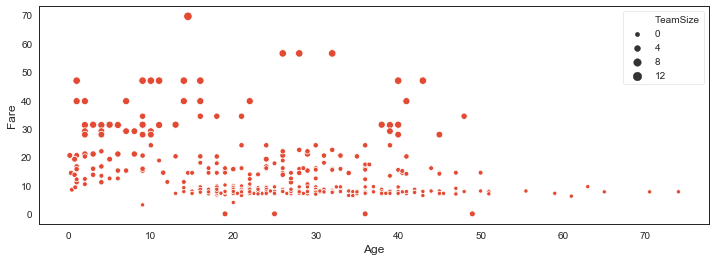

In [76]:
plt.figure(figsize=(12,4))
islice = (df_all['Pclass'] == 3)
sns.scatterplot(x='Age', y='Fare', size= 'TeamSize', data=df_all.loc[islice,:]); plt.show()

df_all['Fare'] = df_all.groupby(['Pclass','TeamSize'])['Fare']\
    .transform(lambda x: x.fillna(x.median()))

In [77]:
print(df_all.loc[973, cols + ['Fare']])

PassengerId                      795
Survived                           0
Name           Dantcheff, Mr. Ristiu
Sex                             male
Age                               25
SibSp                              0
Ticket                        349203
Role                             Man
Embarked                           S
Fare                          7.8958
Fare                          7.8958
Name: 973, dtype: object


#### Impute missing age, TeamSurvivalRate

In [78]:
df_all.columns

df_all['TeamSurvivalRate'] = df_all.groupby(['Pclass','TeamSize'])['TeamSurvivalRate'].apply(lambda x: x.fillna(x.median()))
df_all['weightedSR'] = df_all['SRcredibility'] * df_all['TeamSurvivalRate']
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

displayMissing(df_all)

PassengerId NO. missing values: 0
Survived    NO. missing values: 418
Pclass      NO. missing values: 0
Name        NO. missing values: 0
Sex         NO. missing values: 0
Age         NO. missing values: 0
SibSp       NO. missing values: 0
Parch       NO. missing values: 0
Ticket      NO. missing values: 0
Fare        NO. missing values: 0
Cabin       NO. missing values: 1014
Embarked    NO. missing values: 0
Ticket_num  NO. missing values: 0
Ticket_alp  NO. missing values: 0
TeamSurvivalRate NO. missing values: 0
TeamSize    NO. missing values: 0
FamilySize  NO. missing values: 0
SRcredibility NO. missing values: 0
Role        NO. missing values: 0
childSibSp  NO. missing values: 0
childFamilySize NO. missing values: 0
ChildWAdult NO. missing values: 0
NumChild    NO. missing values: 0
NumYoungChild NO. missing values: 0
youngestChildSurvived NO. missing values: 0
hasMother   NO. missing values: 0
hasFather   NO. missing values: 0
hasBothParents NO. missing values: 0
isMotherSurvived 

Some observations:

0. Ticekt combination provides more information than Family surname.
1. Even in the same family, the survival of female members seems irrelevant to that of male members. See Ticket#19950 for example.
2. There exist records of travel groups formed by non-biological-relationship people (probably, friends or colleauges) with high survival rates.

In [79]:
cols = ['Survived', 'Pclass', 'Ticket', 'Fare', 'Role', 'Age', 'Name', 'isChildSurvived']
# The Davies has two children and two adults (one is maid). The youngest child is alive.
print(df_all.loc[df_all['Ticket_num'] == 33112, cols])

     Survived  Pclass      Ticket   Fare        Role   Age  \
261       0.0       2  C.A. 33112  36.75  olderChild  19.0   
262       1.0       2  C.A. 33112  36.75       Child   8.0   
263       NaN       2  C.A. 33112  36.75       Woman  20.0   
264       NaN       2  C.A. 33112  36.75      Mother  48.0   

                                                  Name isChildSurvived  
261                       Nicholls, Mr. Joseph Charles             Yes  
262                     Davies, Master. John Morgan Jr             Yes  
263                               Sincock, Miss. Maude             Yes  
264  Davies, Mrs. John Morgan (Elizabeth Agnes Mary...             Yes  


In [80]:
print(df_all.loc[df_all['Ticket_num'] == 2079, cols])

     Survived  Pclass           Ticket     Fare    Role   Age  \
991       0.0       2  S.C./PARIS 2079  37.0042  Father  31.0   
992       1.0       2  S.C./PARIS 2079  37.0042   Child   1.0   
993       NaN       2  S.C./PARIS 2079  37.0042  Mother  24.0   

                                        Name isChildSurvived  
991                       Mallet, Mr. Albert             Yes  
992                    Mallet, Master. Andre             Yes  
993  Mallet, Mrs. Albert (Antoinette Magnin)             Yes  


In [81]:
print(df_all.loc[df_all['Ticket_num'] == 36928, cols])  # old family with adult female child

     Survived  Pclass Ticket      Fare   Role   Age  \
519       1.0       1  36928  164.8667  Woman  31.0   
520       1.0       1  36928  164.8667  Woman  45.0   
521       NaN       1  36928  164.8667    Man  57.0   
522       NaN       1  36928  164.8667  Woman  30.0   

                                           Name isChildSurvived  
519                    Wick, Miss. Mary Natalie  Not Applicable  
520  Wick, Mrs. George Dennick (Mary Hitchcock)  Not Applicable  
521                    Wick, Mr. George Dennick  Not Applicable  
522                     Bonnell, Miss. Caroline  Not Applicable  


In [82]:
print(df_all.loc[df_all['Ticket_num'] == 236853, cols])  # couples without children

     Survived  Pclass  Ticket  Fare   Role   Age  \
920       0.0       2  236853  26.0    Man  25.0   
921       NaN       2  236853  26.0  Woman  20.0   

                                    Name isChildSurvived  
920      Bryhl, Mr. Kurt Arnold Gottfrid  Not Applicable  
921  Bryhl, Miss. Dagmar Jenny Ingeborg   Not Applicable  


In [83]:
print(df_all.loc[df_all['Ticket_num'] == 17608, :])  # size of 6

     PassengerId  Survived  Pclass  \
504          312       1.0       1   
505          743       1.0       1   
506          916       NaN       1   
507          951       NaN       1   
508          956       NaN       1   
509         1034       NaN       1   
510         1267       NaN       1   

                                                Name     Sex   Age  SibSp  \
504                       Ryerson, Miss. Emily Borie  female  18.0      2   
505            Ryerson, Miss. Susan Parker "Suzette"  female  21.0      2   
506  Ryerson, Mrs. Arthur Larned (Emily Maria Borie)  female  48.0      1   
507                      Chaudanson, Miss. Victorine  female  36.0      0   
508                      Ryerson, Master. John Borie    male  13.0      2   
509                       Ryerson, Mr. Arthur Larned    male  61.0      1   
510                         Bowen, Miss. Grace Scott  female  45.0      0   

     Parch    Ticket     Fare            Cabin Embarked  Ticket_num  \
504    

In [84]:
print(df_all.loc[df_all['Ticket_num'] == 3101295, cols]) # travel group with female household head

     Survived  Pclass   Ticket     Fare        Role   Age  \
99        0.0       3  3101295  39.6875       Child   7.0   
100       0.0       3  3101295  39.6875       Child   1.0   
101       0.0       3  3101295  39.6875  olderChild  16.0   
102       0.0       3  3101295  39.6875      Mother  41.0   
103       0.0       3  3101295  39.6875       Child  14.0   
104       0.0       3  3101295  39.6875       Child   2.0   
105       NaN       3  3101295  39.6875       Woman  22.0   

                                             Name isChildSurvived  
99                     Panula, Master. Juha Niilo              No  
100                  Panula, Master. Eino Viljami              No  
101                     Panula, Mr. Ernesti Arvid              No  
102        Panula, Mrs. Juha (Maria Emilia Ojala)              No  
103                      Panula, Mr. Jaako Arnold              No  
104                  Panula, Master. Urho Abraham              No  
105  Riihivouri, Miss. Susanna Juha

In [85]:
print(df_all.loc[df_all['Ticket_num'] == 2144, cols]) # Class 3. mother with six children died

     Survived  Pclass   Ticket  Fare        Role   Age  \
121       0.0       3  CA 2144  46.9       Child  11.0   
122       0.0       3  CA 2144  46.9  olderChild  16.0   
123       0.0       3  CA 2144  46.9       Child   1.0   
124       0.0       3  CA 2144  46.9       Child   9.0   
125       0.0       3  CA 2144  46.9      Mother  43.0   
126       0.0       3  CA 2144  46.9       Child  14.0   
127       NaN       3  CA 2144  46.9      Father  40.0   
128       NaN       3  CA 2144  46.9       Child  10.0   

                                        Name isChildSurvived  
121       Goodwin, Master. William Frederick              No  
122               Goodwin, Miss. Lillian Amy              No  
123          Goodwin, Master. Sidney Leonard              No  
124           Goodwin, Master. Harold Victor              No  
125  Goodwin, Mrs. Frederick (Augusta Tyler)              No  
126              Goodwin, Mr. Charles Edward              No  
127           Goodwin, Mr. Charles F

In [86]:
print(df_all.loc[df_all['Ticket_num'] == 347742, cols]) # class 3. mother with two children alive

    Survived  Pclass  Ticket     Fare    Role   Age  \
15       1.0       3  347742  11.1333  Mother  27.0   
16       1.0       3  347742  11.1333   Child   1.0   
17       1.0       3  347742  11.1333   Child   4.0   

                                                 Name isChildSurvived  
15  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)             Yes  
16                       Johnson, Miss. Eleanor Ileen             Yes  
17                    Johnson, Master. Harold Theodor             Yes  


In [87]:
print(df_all.loc[df_all['Ticket_num'] == 347077, cols])  # class 3 mother with five children alive

    Survived  Pclass  Ticket     Fare    Role   Age  \
49       1.0       3  347077  31.3875  Mother  38.0   
50       0.0       3  347077  31.3875   Child   9.0   
51       1.0       3  347077  31.3875   Child   5.0   
52       1.0       3  347077  31.3875   Child   3.0   
53       NaN       3  347077  31.3875   Child  13.0   
54       NaN       3  347077  31.3875  Father  40.0   
55       NaN       3  347077  31.3875   Child   5.0   

                                                 Name isChildSurvived  
49  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...              No  
50              Asplund, Master. Clarence Gustaf Hugo              No  
51                     Asplund, Miss. Lillian Gertrud              No  
52                  Asplund, Master. Edvin Rojj Felix              No  
53                       Asplund, Master. Filip Oscar              No  
54         Asplund, Mr. Carl Oscar Vilhelm Gustafsson              No  
55                        Asplund, Master. Carl Edgar  

In [88]:
print(df_all.loc[df_all['Ticket_num'] == 1601, cols]) # class 3. group of eight non-biological-related male members

     Survived  Pclass Ticket     Fare Role   Age             Name  \
158       1.0       3   1601  56.4958  Man  32.0    Bing, Mr. Lee   
159       0.0       3   1601  56.4958  Man  28.0    Ling, Mr. Lee   
160       1.0       3   1601  56.4958  Man  26.0   Lang, Mr. Fang   
161       1.0       3   1601  56.4958  Man  25.0  Foo, Mr. Choong   
162       1.0       3   1601  56.4958  Man  25.0     Lam, Mr. Ali   
163       0.0       3   1601  56.4958  Man  25.0     Lam, Mr. Len   
164       1.0       3   1601  56.4958  Man  32.0  Chip, Mr. Chang   
165       NaN       3   1601  56.4958  Man  25.0    Hee, Mr. Ling   

    isChildSurvived  
158  Not Applicable  
159  Not Applicable  
160  Not Applicable  
161  Not Applicable  
162  Not Applicable  
163  Not Applicable  
164  Not Applicable  
165  Not Applicable  


In [89]:
for i, g in df_all.groupby(['Pclass', 'Sex'])['Age'].groups.items():
    if i == (1, 'female'):
        tb = df_all.groupby(['Pclass', 'Sex'])['Age'].get_group(i)
        break
print(pd.DataFrame(tb).head(10).T)

       1     4     23    58    59    61    62    66    67    72
Age  38.0  35.0  58.0  23.0  24.0  28.0  60.0  36.0  58.0  36.0


Distribution of age by passenger class and gender

In [90]:
df_all.iloc[:891,:].to_csv('c_train.csv', index=False)
df_all.iloc[891:,:].to_csv('c_test.csv', index=False)

# Histograms by passenger class, sex, age groups

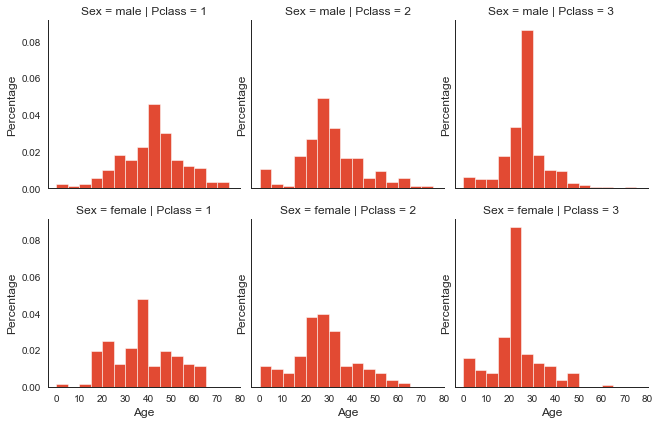

In [91]:
import string
alpha_list = list(string.ascii_lowercase[:9])
# Seaborn facet grid plot
g = sns.FacetGrid(df_all, col='Pclass', row='Sex')
g = g.map(plt.hist, 'Age', bins=np.arange(0, 80, 5), density=True)

for ax in g.axes.flat:
    # Step 1. Get section
    texts = ax.get_xticklabels()
    locations = ax.get_xticks()
    ylabel = ax.yaxis.get_label()
    # Step 2. Set section
    if ylabel:
        ax.set_ylabel("Percentage")
    ax.set_xticks(np.arange(0,81,10))
    # ax.set_xticklabels(alpha_list) # experimental. works well.
    ax.set_xticklabels(np.arange(0, 81,10))

plt.show()

<a id="stacked-survival-count"></a>
#### Stacked hist plot of survived people by gender
Step 1. list the total number of survived people by gender and passenger class.

In [92]:
c = df_all.groupby(['Pclass', 'Sex'])['Survived'].sum().astype(int).rename("count")
c

Pclass  Sex   
1       female    91
        male      45
2       female    70
        male      17
3       female    72
        male      47
Name: count, dtype: int32

Step 2-A. list the total number of people with available Survived data by gender and passenger class. 

In [93]:
d = df_all.groupby(['Pclass', 'Sex'])['Survived'].apply(lambda x: pd.notnull(x).sum())
print(d)

Pclass  Sex   
1       female     94
        male      122
2       female     76
        male      108
3       female    144
        male      347
Name: Survived, dtype: int64


Step 2-B. regardless of gender, list the total number of people with available Survived data by passenger class.

In [94]:
print(d.groupby(level=0).sum())

Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64


Step 3-A. Compute the survial rate based on availabe Survived feature by gender and passenger class.

In [95]:
c / d

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
dtype: float64

Step 3-B. Compute the survival rate in respective passenger class across gendear and passenger class. This computation is useless because the survival rate might be distorted by the imbalanced size of population across genders.

In [96]:
e = c / d.groupby(level=0).sum()
e

Pclass  Sex   
1       female    0.421296
        male      0.208333
2       female    0.380435
        male      0.092391
3       female    0.146640
        male      0.095723
dtype: float64

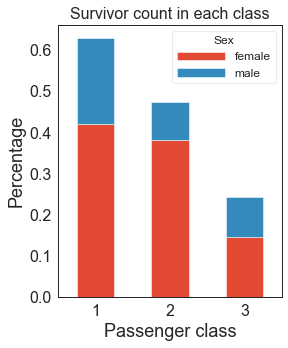

In [97]:
params = {'figure.figsize': (15, 6),
          'axes.labelsize': 18,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.title_fontsize': 12,
          'legend.fontsize': 12,
          'legend.handlelength': 4}
pylab.rcParams.update(params)

fig, ax = plt.subplots()
f = e.unstack(level=-1)
f.plot(kind='bar', stacked=True, fontsize=16, ax=ax)

fig.set_size_inches(4,5)
ax.set_xlabel('Passenger class')
ax.set_ylabel('Percentage')
ax.set_title('Survivor count in each class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

Now I'm interested to plot a refined version of the aforementioned survivor analysis with the decomposition by age and gender in each class.

In [98]:
grouped = df_all.groupby(['Pclass', 'Sex', pd.cut(df_all['Age'],bins=range(0,80,10))])
unpivoted = grouped['Survived'].apply(lambda x: x.sum()).reset_index()
print(unpivoted.head(14).T)

                0         1         2         3         4         5         6  \
Pclass          1         1         1         1         1         1         1   
Sex        female    female    female    female    female    female    female   
Age       (0, 10]  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  (60, 70]   
Survived        0        13        20        33        12        11         2   

                7         8         9        10        11        12        13  
Pclass          1         1         1         1         1         1         1  
Sex          male      male      male      male      male      male      male  
Age       (0, 10]  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  (60, 70]  
Survived        2         2         9        13        14         4         0  


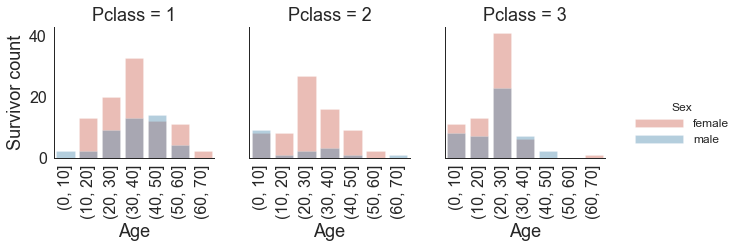

In [99]:
# Part I. major visualization
g = sns.FacetGrid(unpivoted, col='Pclass', hue='Sex', margin_titles=True)
g = g.map(sns.barplot, 'Age', 'Survived', alpha=0.4)
# Part II.  
g.add_legend()
for i, ax in enumerate(g.axes.flat):
    # Step 1. get information
    labels = ax.get_xticklabels() # get x labels
    ylabel = ax.yaxis.get_label()
    # Step 2. update information
    if i==0: ax.set_ylabel('Survivor count')
#     for i,l in enumerate(labels):
#         if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels

I would like to have a stacked bar chart instead of an overlapping transparent bar chart as shown above. Here is my more refined approach to contrast female survior head count against male's by age group.

In [100]:
# Step 1. Generate the head count by Pclas, Sex and age group
grouped = df_all.groupby(['Pclass', 'Sex', pd.cut(df_all['Age'],bins=range(0,80,10))])
x = grouped['Survived'].apply(lambda x: x.sum()).reset_index()
x

# Step 2. unstack Sex so that we have male and female columns
y = x.set_index(['Pclass', 'Age', 'Sex']).unstack(level=-1)
# drop the column index before summation
y.columns = y.columns.droplevel()
y['total'] = y['female'] + y['male']
y

# Step 3. drop the intermediate column and then rename
# Note: the value of female column is actually the sum of the original numbers of female and male.
del y['female']
y = y.rename(columns={'total': 'female'})
unpivoted = y.fillna(0)

# Step 4. Transform back to a data frame with Pclass, Age, Sex, Survived columns
unpivoted = unpivoted.stack()
unpivoted = unpivoted.to_frame(name='Survived')
unpivoted
unpivoted = unpivoted.reset_index()
unpivoted;

In [101]:
unpivoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    42 non-null     int64   
 1   Age       42 non-null     category
 2   Sex       42 non-null     object  
 3   Survived  42 non-null     float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 1.6+ KB


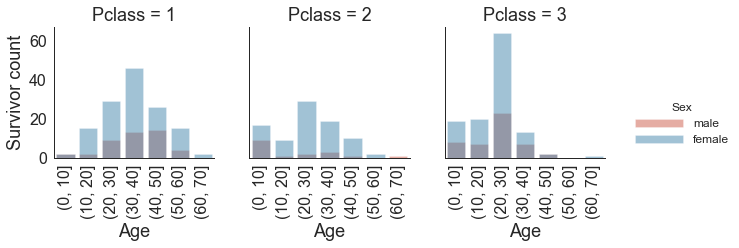

In [102]:
# Step 5.
g = sns.FacetGrid(unpivoted, col='Pclass', hue='Sex', margin_titles=True)
g = g.map(sns.barplot, 'Age', 'Survived', alpha=0.5)
# Part II.
g.add_legend()
for i, ax in enumerate(g.axes.flat):
    # Step 1. get information
    labels = ax.get_xticklabels() # get x labels
    ylabel = ax.yaxis.get_label()
    # Step 2. update information
    if i==0: ax.set_ylabel('Survivor count')
#     for i,l in enumerate(labels):
#         if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
plt.show()

I am not satisfied with the rendering above. Here is the alternative version with a helper function.

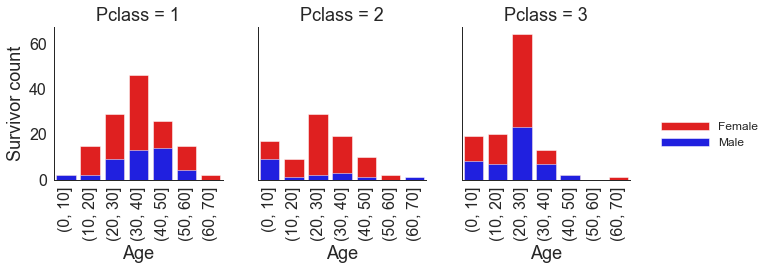

In [103]:
def sbp(*args, **kwargs):
    data = kwargs.pop('data')
    sns.barplot(x = data.Age, y = data.loc[data.Sex == 'female', 'Survived'], color = 'red', label = 'Female')
    sns.barplot(x = data.Age, y = data.loc[data.Sex == 'male', 'Survived'], color = 'blue', label = 'Male') 
    
unpivoted['Age'] = unpivoted['Age'].astype(str) # This is the key statement for the following mapping works.
                                                # It lets you to convert categorical to str.
    
g = sns.FacetGrid(unpivoted, col='Pclass', margin_titles=True, legend_out=True)
g = g.map_dataframe(sbp, Age='Age', Sex='Sex')

g.add_legend()
for i, ax in enumerate(g.axes.flat):
    # Step 1. get information
    labels = ax.get_xticklabels() # get x labels
    ylabel = ax.yaxis.get_label()
    # Step 2. update information
    if i==0: ax.set_ylabel('Survivor count')
#     for i,l in enumerate(labels):
#         if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=90) # set new labels
    ax.set_xlabel('Age')
plt.show()

No more transparency issue undermines the visualization. Female and male bars are marked respectively in solid color. And the number of survived female passengers are seemingly stacked ontop of their male counterpart across age groups.  

That's it. If you find the mining of demographic features or any of the Pandas and Seaborn trickes helpful, please upvote my post. I will dig on the Titanic survival prediction in my next post. See you later.